### Dependencies

In [1]:
# Link for the script https://www.kaggle.com/dimitreoliveira/cloud-images-segmentation-utillity-script
from cloud_images_segmentation_utillity_script import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])
test['set'] = 'test'

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105
Test samples: 14792


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [3]:
BACKBONE = 'densenet169'
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 3e-4
HEIGHT = 256
WIDTH = 384
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

model_name = 'uNet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)
model_path = '../working/%s' % (model_name)
submission_path = model_name +'_submission.csv'
submission_post_path = model_name + '_submission_post.csv'

train_images_path = '../input/cloud-images-resized-256x384/train_images256x384/train_images256x384/'
validation_images_path = '../input/cloud-images-resized-256x384/validation_images256x384/validation_images256x384/'
test_images_path = '../input/cloud-images-resized-256x384/test_images256x384/test_images256x384/'

In [4]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=45, 
                                                   shift_limit=0.1, border_mode=0, p=0.5),
                             albu.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
                             albu.Rotate(limit=45, p=0.5)
                            ])

### Data generator

In [5]:
train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=validation_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [6]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

51879936/51877672 [==============================] - 157s 3us/step
Model: "u-densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 384, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 390, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 192, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 192, 64) 256         conv1/conv[0][0]                 
___________________

In [7]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/30
 - 371s - loss: 1.4012 - dice_coef: 0.2732 - iou_score: 0.1214 - score: 0.1874 - val_loss: 1.2713 - val_dice_coef: 0.3133 - val_iou_score: 0.1412 - val_score: 0.2139
Epoch 2/30
 - 299s - loss: 1.1712 - dice_coef: 0.3505 - iou_score: 0.1447 - score: 0.2159 - val_loss: 1.1549 - val_dice_coef: 0.3992 - val_iou_score: 0.1666 - val_score: 0.2420
Epoch 3/30
 - 313s - loss: 1.0887 - dice_coef: 0.4033 - iou_score: 0.1589 - score: 0.2314 - val_loss: 1.1183 - val_dice_coef: 0.4317 - val_iou_score: 0.1816 - val_score: 0.2567
Epoch 4/30
 - 315s - loss: 1.0641 - dice_coef: 0.4281 - iou_score: 0.1666 - score: 0.2393 - val_loss: 1.0236 - val_dice_coef: 0.4674 - val_iou_score: 0.1918 - val_score: 0.2672
Epoch 5/30
 - 325s - loss: 1.0544 - dice_coef: 0.4367 - iou_score: 0.1706 - score: 0.2435 - val_loss: 1.0731 - val_dice_coef: 0.4648 - val_iou_score: 0.1824 - val_score: 0.2540
Epoch 6/30
 - 316s - loss: 1.0471 - dice_coef: 0.4446 - iou_score: 0.1745 - score: 0.2478 - val_loss: 1.0035 - val_

## Model loss graph

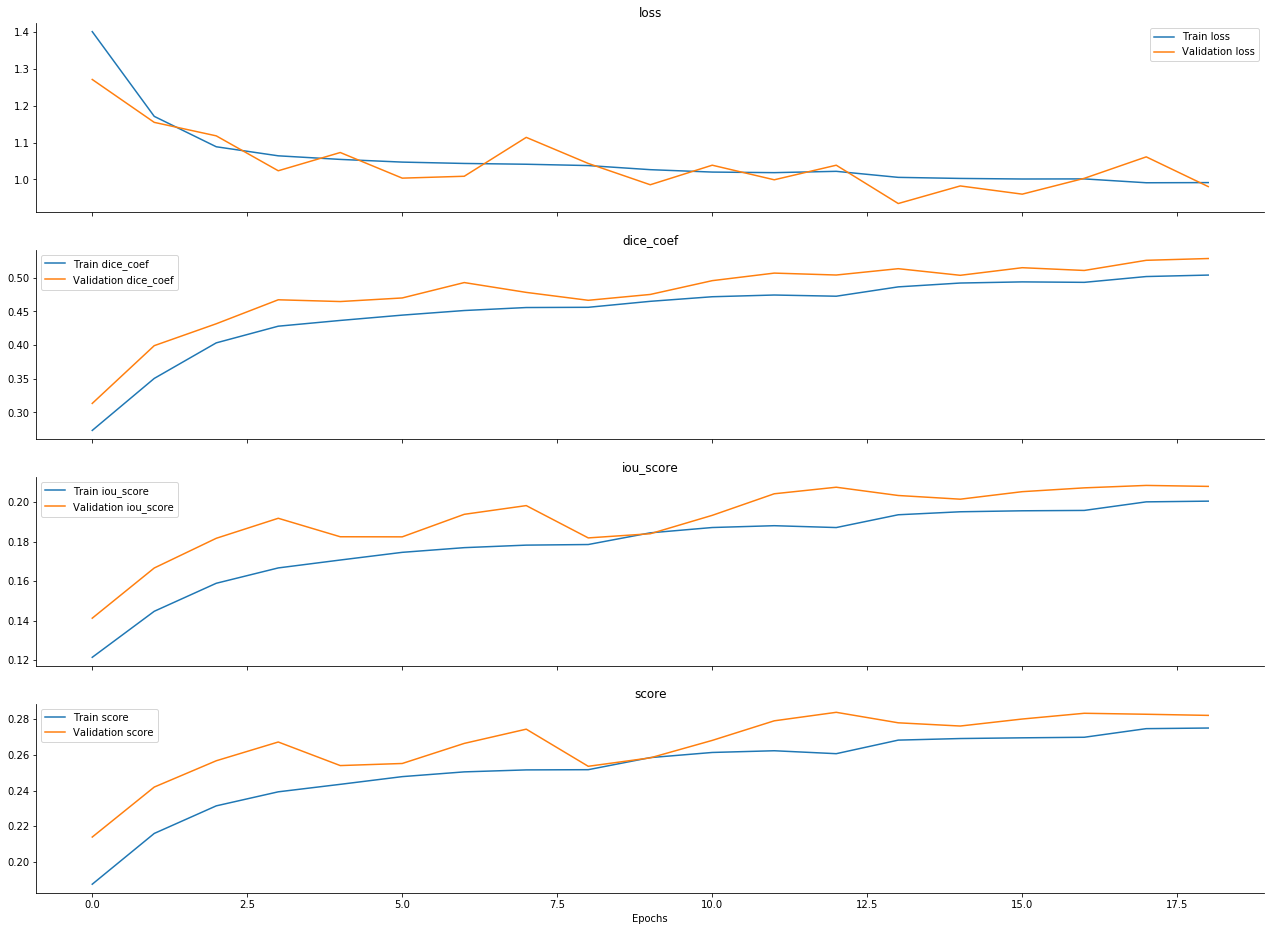

In [8]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'score'])

# Threshold and mask size tunning

In [9]:
class_names = ['Fish  ', 'Flower', 'Gravel', 'Sugar ']
mask_grid = [0, 500, 1000, 5000, 7500, 10000, 15000]
threshold_grid = np.arange(.5, 1, .05)
metrics = []

for class_index in range(N_CLASSES):
    for threshold in threshold_grid:
        for mask_size in mask_grid:
            metrics.append([class_index, threshold, mask_size, 0])

metrics_df = pd.DataFrame(metrics, columns=['Class', 'Threshold', 'Mask size', 'Dice'])

for i in range(0, X_val.shape[0], 500):
    batch_idx = list(range(i, min(X_val.shape[0], i + 500)))
    batch_set = X_val[batch_idx[0]: batch_idx[-1]+1]
    ratio = len(batch_set) / len(X_val)
    
    generator = DataGenerator(
                  directory=validation_images_path,
                  dataframe=batch_set,
                  target_df=train,
                  batch_size=len(batch_set), 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed,
                  mode='fit',
                  shuffle=False)
    
    x, y = generator.__getitem__(0)
    preds = model.predict(x)

    for class_index in range(N_CLASSES):
        class_score = []
        label_class = y[..., class_index]
        pred_class = preds[..., class_index]
        for threshold in threshold_grid:
            for mask_size in mask_grid:
                mask_score = []
                for index in range(len(batch_idx)):
                    label_mask = label_class[index, ]
                    pred_mask = pred_class[index, ]
                    pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                    dice_score = dice_coefficient(pred_mask, label_mask)
                    if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                        dice_score = 1.
                    mask_score.append(dice_score)
                metrics_df.loc[(metrics_df['Class'] == class_index) & (metrics_df['Threshold'] == threshold) & 
                               (metrics_df['Mask size'] == mask_size), 'Dice'] += np.mean(mask_score) * ratio

metrics_df_0 = metrics_df[metrics_df['Class'] == 0]
metrics_df_1 = metrics_df[metrics_df['Class'] == 1]
metrics_df_2 = metrics_df[metrics_df['Class'] == 2]
metrics_df_3 = metrics_df[metrics_df['Class'] == 3]

optimal_values_0 = metrics_df_0.loc[metrics_df_0['Dice'].idxmax()].values
optimal_values_1 = metrics_df_1.loc[metrics_df_1['Dice'].idxmax()].values
optimal_values_2 = metrics_df_2.loc[metrics_df_2['Dice'].idxmax()].values
optimal_values_3 = metrics_df_3.loc[metrics_df_3['Dice'].idxmax()].values

best_tresholds = [optimal_values_0[1], optimal_values_1[1], optimal_values_2[1], optimal_values_3[1]]
best_masks = [optimal_values_0[2], optimal_values_1[2], optimal_values_2[2], optimal_values_3[2]]
best_dices = [optimal_values_0[3], optimal_values_1[3], optimal_values_2[3], optimal_values_3[3]]

for index, name in enumerate(class_names):
    print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))

Fish   treshold=0.50 mask size=15000 Dice=0.592
Flower treshold=0.55 mask size=15000 Dice=0.756
Gravel treshold=0.55 mask size=10000 Dice=0.596
Sugar  treshold=0.50 mask size=10000 Dice=0.606


# Model evaluation

In [10]:
train_metrics = get_metrics(model, train, X_train, train_images_path, best_tresholds, best_masks, seed=seed, preprocessing=preprocessing, set_name='Train')
display(train_metrics)

validation_metrics = get_metrics(model, train, X_val, validation_images_path, best_tresholds, best_masks, seed=seed, preprocessing=preprocessing, set_name='Validation')
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.214287,0.614876
Flower,0.194342,0.766738
Gravel,0.220013,0.607872
Sugar,0.248956,0.605206
Train,0.219400,0.648673


,Dice,Dice Post
Class,,
Fish,0.217359,0.591899
Flower,0.203432,0.756076
Gravel,0.215726,0.595839
Sugar,0.249860,0.605693
Validation,0.221594,0.637377


# Apply model to test set

In [11]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

### Regular submission

In [12]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,7 222 257 63 357 222 607 63 704 341 1053 343 1...
3,002f507.jpg_Sugar,121620 14 121968 24 122314 30 122664 30 123013...
4,0035ae9.jpg_Fish,110282 2 110632 2 110980 2 113082 1 113432 1 1...


### Submission with post processing

In [13]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,13 213 263 15 287 17 363 213 613 15 637 17 704...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
